# Логичтическая регрессия, метод опорных векторов, one-hot кодирование

### О задании

В этом задании вы изучите методы работы с категориальными переменными

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

__Задание 1.__ Обучение логистической регрессии на реальных данных и оценка качества классификации.

**(2 балла)**


Загрузим данные с конкурса [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом под нужды задания мы немного модифицируем датасет.

In [6]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

print("Форма данных:", data.shape)
print("Форма целевой переменной:", target.shape)
print(data.head())

Форма данных: (595212, 57)
Форма целевой переменной: (595212,)
    ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  ps_ind_05_cat  \
id                                                                      
7           2              2          5              1              0   
9           1              1          7              0              0   
13          5              4          9              1              0   
16          0              1          2              0              0   
17          0              2          0              1              0   

    ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  ps_ind_09_bin  ps_ind_10_bin  \
id                                                                              
7               0              1              0              0              0   
9               0              0              1              0              0   
13              0              0              1              0              0   
16              1   

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.

In [7]:
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

Не забудьте отнормировать признаки (можно воспользоваться StandardScaler или сделать это вручную). Пока не будем обращать внимание на то, что некоторые признаки категориальные (этим мы займёмся позже).

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Размеры обучающей выборки:", X_train_scaled.shape)
print("Размеры тестовой выборки:", X_test_scaled.shape)

Размеры обучающей выборки: (100000, 57)
Размеры тестовой выборки: (100000, 57)


Обучите логистическую регрессию с удобными для вас параметрами, примените регуляризацию, найдтие оптимум. Сделайте предсказание на тестовой части выборки. Замерьте качество.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
log_reg = LogisticRegression(solver='liblinear', max_iter=100)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],       
}

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print("Лучшие параметры:", grid_search.best_params_)

best_log_reg = grid_search.best_estimator_
y_pred = best_log_reg.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Точность на тестовой выборке:", accuracy)
print("Отчет по классификации:\n", report)

Лучшие параметры: {'C': 0.01, 'penalty': 'l1'}
Точность на тестовой выборке: 0.58828
Отчет по классификации:
               precision    recall  f1-score   support

           0       0.58      0.63      0.61     49994
           1       0.60      0.54      0.57     50006

    accuracy                           0.59    100000
   macro avg       0.59      0.59      0.59    100000
weighted avg       0.59      0.59      0.59    100000



__Выводы__ в свободной форме:

__Задание 2.__ Изучение влияния регуляризатора на процесс обучения

__(2 балла)__

Проверьте на практике, как влияет регуляризатор на процесс обучения (убывание функции потерь на обучающей и отложенной выборках). Чтобы считать функцию потерь на отложенной выборке после каждой итерации, запускайте процесс обучения логистической регрессии с параметром $max\_iter=1$ и $w^{(0)}$, полученным на предыдущей итерации. Постройте два графика: на одном из них логистическая регрессия с коэффициентом регуляризации, равным 0, а на другом с некоторым разумным значением. На каждом графике одновременно должна быть и функция потерь для обучающей, и для тестовой выборки. Не забудьте сделать одинаковыми оси обоих графиков. Какие выводы вы можете сделать?

In [47]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings("ignore", category=ConvergenceWarning)

def train_and_evaluate(X_train, y_train, X_test, y_test, penalty, C=None):
    if penalty == None:
        log_reg = LogisticRegression(solver='saga', max_iter=1, penalty=None, warm_start=True)
    else:
        log_reg = LogisticRegression(solver='saga', max_iter=1, penalty=penalty, C=C, warm_start=True)
    
    train_losses = []
    test_losses = []
    

    for i in range(1, 101):
        log_reg.fit(X_train, y_train)
        
        y_train_pred_proba = log_reg.predict_proba(X_train)[:, 1]
        y_test_pred_proba = log_reg.predict_proba(X_test)[:, 1]
        
        train_loss = log_loss(y_train, y_train_pred_proba)
        test_loss = log_loss(y_test, y_test_pred_proba)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        if penalty == None:
            print(f"Iteration {i}: penalty = none, Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")
        else:
            print(f"Iteration {i}: penalty = {penalty}, C = {C:.5e}, Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")
    
    return train_losses, test_losses

train_losses_no_reg, test_losses_no_reg = train_and_evaluate(
    X_train_scaled, y_train, X_test_scaled, y_test, penalty=None
)

train_losses_reg, test_losses_reg = train_and_evaluate(
    X_train_scaled, y_train, X_test_scaled, y_test, penalty='l2', C=5.1
)

Iteration 1: penalty = none, Train Loss = 0.6687, Test Loss = 0.6697
Iteration 2: penalty = none, Train Loss = 0.6689, Test Loss = 0.6696
Iteration 3: penalty = none, Train Loss = 0.6687, Test Loss = 0.6699
Iteration 4: penalty = none, Train Loss = 0.6689, Test Loss = 0.6699
Iteration 5: penalty = none, Train Loss = 0.6687, Test Loss = 0.6696
Iteration 6: penalty = none, Train Loss = 0.6687, Test Loss = 0.6699
Iteration 7: penalty = none, Train Loss = 0.6686, Test Loss = 0.6697
Iteration 8: penalty = none, Train Loss = 0.6691, Test Loss = 0.6703
Iteration 9: penalty = none, Train Loss = 0.6688, Test Loss = 0.6702
Iteration 10: penalty = none, Train Loss = 0.6686, Test Loss = 0.6699
Iteration 11: penalty = none, Train Loss = 0.6687, Test Loss = 0.6702
Iteration 12: penalty = none, Train Loss = 0.6689, Test Loss = 0.6700
Iteration 13: penalty = none, Train Loss = 0.6686, Test Loss = 0.6698
Iteration 14: penalty = none, Train Loss = 0.6687, Test Loss = 0.6700
Iteration 15: penalty = none,

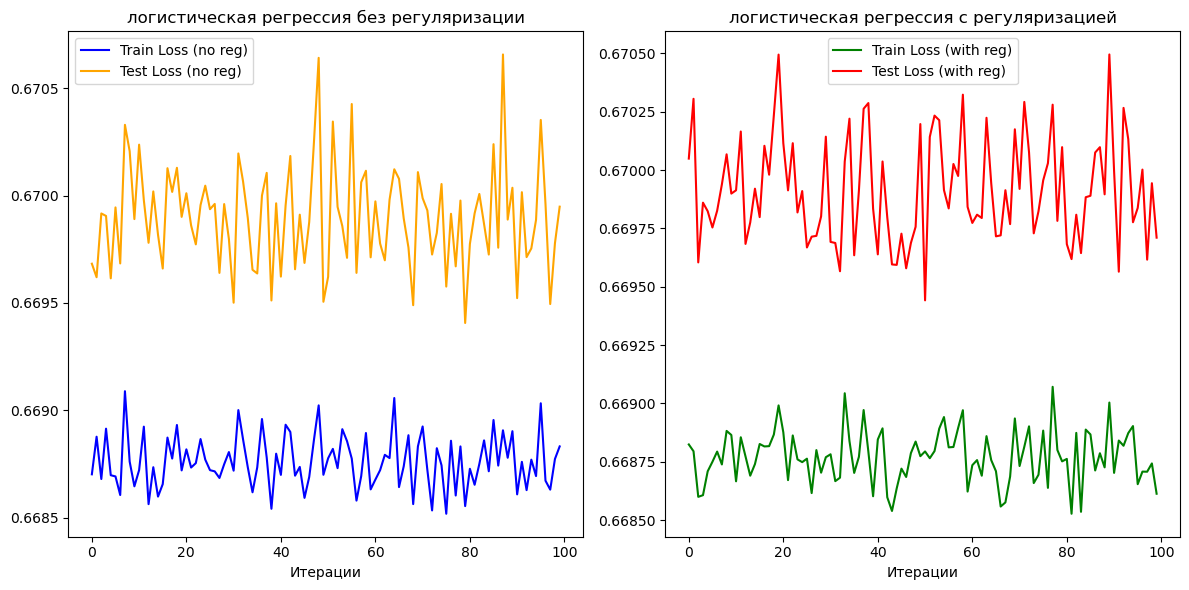

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# без регуляризации
plt.subplot(1, 2, 1)
plt.plot(train_losses_no_reg, label='Train Loss (no reg)', color='blue')
plt.plot(test_losses_no_reg, label='Test Loss (no reg)', color='orange')
plt.title('логистическая регрессия без регуляризации')
plt.xlabel('Итерации')
plt.legend()

#  с регуляризацией
plt.subplot(1, 2, 2)
plt.plot(train_losses_reg, label='Train Loss (with reg)', color='green')
plt.plot(test_losses_reg, label='Test Loss (with reg)', color='red')
plt.title('логистическая регрессия с регуляризацией')
plt.xlabel('Итерации')
plt.legend()

plt.tight_layout()
plt.show()

__Выводы:__ На графике без регуляризации можно ожидать низкую функцию потерь на обучающей выборке и высокую на тестовой выборке. Это может указывать на переобучение модели.
На графике с регуляризацией мы должны увидеть более сбалансированные значения функции потерь на обучающей и тестовой выборках. Регуляризация помогает предотвратить переобучение и улучшает обобщающую способность модели.

Таким образом, регуляризация играет важную роль в контроле сложности модели и ее способности к обобщению на новых данных.

## Часть 2. Работа с категориальными переменными

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Задание 1.__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было ранее). Измерьте время, потребовавшееся на обучение модели.

__(3 балла)__

In [28]:
import time
from sklearn.model_selection import GridSearchCV

# One-hot-кодирование категориальных признаков
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

log_reg = LogisticRegression(solver='liblinear', max_iter=100)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],       
}

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')

start_time = time.time()
grid_search.fit(X_train_scaled, y_train)
training_time = time.time() - start_time

best_log_reg = grid_search.best_estimator_
y_pred = best_log_reg.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Время обучения модели: {training_time:.4f} секунд")
print(f"Точность модели: {accuracy:.4f}")

Время обучения модели: 82.8026 секунд
Точность модели: 0.5883


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 2.__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментов. Заметили ли вы что-то интересное?

__(2 балла)__

In [21]:
def target_encoding(X, y):
    for col in X.select_dtypes(include=['object']).columns:
        mean_target = X.groupby(col)[y.name].mean()
        # Заменяем категориальные значения на средние
        X[col] = X[col].map(mean_target)
    return X

X_train_encoded = target_encoding(X_train.copy(), y_train)
X_test_encoded = target_encoding(X_test.copy(), y_test)

log_reg = LogisticRegression(solver='liblinear', max_iter=100)

start_time = time.time()
log_reg.fit(X_train_encoded, y_train)
training_time = time.time() - start_time

y_pred = log_reg.predict(X_test_encoded)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Время обучения модели с кодированием счётчиков: {training_time:.4f} секунд")
print(f"Точность модели с кодированием счётчиков: {accuracy:.4f}")

Время обучения модели с кодированием счётчиков: 7.7679 секунд
Точность модели с кодированием счётчиков: 0.5880


__Вывод:__ Время обучения модели с помощью счётчиков намного меньше времени обучения с помощью one-hot-кодирования. Это может быть связано с тем, что one-hot-кодирование может значительно увеличивать размерность данных, а также категории, возможно, имели значительную связь с целевой переменной. При этом точность моделей в обоих случаях приблизительно одинаковая.

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
- вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени)
- вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации)
- внесение некоторого шума в посчитанные признаки (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков).

__Задание 3.__ Реализуйте корректное вычисление счётчиков двумя из трех вышеперчисленных способов, сравните. Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(3 балла)__

__Вывод:__